# Basic Architecture for 1D Convolutional Neural Networks

---

## Introduction

Convolution Neural Networks (CNNs) are a class of deep learning models specifically designed for processing data with a grid-like topology, such as images. CNNs have revolutionized the field of computer vision by achieving state-of-the-art results in tasks like image classification, object detection, and segmentation.

The key idea behind CNNs is the use of convolutional layers, which apply filters to local regions of the input data to extract hierarchical features. These layers are typically followed by pooling layers that reduce the spatial dimensions, making the network more efficient and robust to spatial variations.

CNNs are composed of several types of layers:
- **Convolutional Layers:** Extract local features using learnable filters.
- **Activation Functions:** Introduce non-linearity (commonly ReLU).
- **Pooling Layers:** Downsample feature maps to reduce computation and control overfitting.
- **Fully Connected Layers:** Combine features for final classification or regression tasks.

Due to their ability to automatically learn spatial hierarchies of features, CNNs are widely used in image and video analysis, medical image processing, and many other domains.

![CNN autoencoder](https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/b6/f4/variational-autoencoder-neural-network.component.xl.ts=1744887318491.png/content/adobe-cms/us/en/think/topics/latent-space/jcr:content/root/table_of_contents/body-article-8/image)

Below you can reconstruct a model architecture using Netron package.
Netron notation works like this:

`W <C_out×C_in×K>`
* **C\_out**: Number of filters (output channels).
* **C\_in**: Number of input channels.
* **K**: Kernel size (window length).

Example: `W <16×1×5>` indicates 16 filters, each looking at 1 channel with a window of length 5.

In [34]:
SCRIPT_DIR = os.getcwd()
PYISV_ROOT = os.path.abspath(os.path.join(SCRIPT_DIR, '..'))

models_dir = os.path.join(PYISV_ROOT, 'models')

# Visualize with Netron
# Can be installed via pip: pip install netron
# or conda: conda install -c conda-forge netron
import netron

onnx_path = f"{models_dir}/best_autoencoder_model.onnx"
netron.start(onnx_path)
# This will open a browser window with the model visualization.

Serving '/Users/frasera/Ricerca/PyISV/models/best_autoencoder_model.onnx' at http://localhost:21103


('localhost', 21103)

---

## Channels, Biases, and Filters


### Input Tensor Shapes

In PyTorch, a 1D convolutional layer expects input tensors of shape:

```
(batch_size, in_channels, signal_length)
```

* **batch\_size**: Number of samples processed in parallel.
* **in\_channels**: Number of feature maps per sample (channels).
* **signal\_length**: Number of discrete steps per sample (e.g., time steps or histogram bins).

Higher dimensional inputs would include signal_height, and so on.

**Example:** A batch of 32 KDE feature vectors with one channel and 100 bins has shape `(32, 1, 100)`.

In [31]:
# Example: batch of 32 KDE feature vectors, 1 channel, 100 bins
import torch
batch_size = 32
in_channels = 1
signal_length = 100
x = torch.randn(batch_size, in_channels, signal_length)
print("Input shape:", x.shape)  # Output: torch.Size([32, 1, 100])

Input shape: torch.Size([32, 1, 100])


### Channels vs Spatial Dimensions

* **Channels** represent parallel feature sequences (different maps) stacked along the channel axis, each learned by a separate filter.
* **Spatial dimensions** (length, for 1D) represent the position or order in the input signal that filters slide over.

> **Note:** Visualization tools like Netron may display 1D data as an image of size `1×1×signal_length`, treating bins as channels. In practice for Conv1d, interpret `(in_channels, signal_length)` directly.



### Convolutional Filters: Shapes and Parameters

A Conv1d layer is defined by:

```python
nn.Conv1d(in_channels=C_in,
          out_channels=C_out,
          kernel_size=K)
```

* **C\_in**: Number of input channels.
* **C\_out**: Number of filters, and thus output channels.
* **K**: Kernel size—i.e., the length of the sliding window on the input signal.

The weight tensor has shape:

```
(C_out, C_in, K)
```

and the bias tensor (if used) has shape:

```
(C_out,)
```

> **Kernel window example:** If `kernel_size = 3`, each filter examines 3 consecutive steps in the signal (e.g., bins 5–7) at each position.

* The layer contains `C_out` filters, each with its own weights and bias.
* All filters scan the full input in parallel, producing `C_out` feature maps.
* These feature maps are stacked along the output channel axis, yielding an output tensor of shape `(batch_size, C_out, L_out)`.
* Each filter has one bias scalar added to its output at every position:
  $\text{output} = \text{activation}(w \cdot x + b)$
* Bias allows the activation function to shift, improving the model's flexibility.
* There are `C_out` biases in total.

In [32]:
import torch.nn as nn
# Define a Conv1d layer
conv = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5)
print("Weight shape:", conv.weight.shape)  # torch.Size([16, 1, 5])
print("Bias shape:", conv.bias.shape)      # torch.Size([16])

Weight shape: torch.Size([16, 1, 5])
Bias shape: torch.Size([16])


### Output Shape

For input length `L_in`, kernel size `K`, stride `S` (default 1), and no padding, the output length is:
```
L_out = floor((L_in - K) / S) + 1
```
So the full output tensor is shaped:
```
(batch_size, C_out, L_out)
```

In [33]:
import torch
import torch.nn as nn
# Input: batch_size=32, in_channels=1, signal_length=100
x = torch.randn(32, 1, 100)
conv = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
y = conv(x)
print("Output shape:", y.shape)  # torch.Size([32, 16, 96])

Output shape: torch.Size([32, 16, 96])


![GIF filters](https://www.cs.cmu.edu/~bhiksha/courses/deeplearning/Spring.2019/archive-f19/www-bak11-22-2019/document/note/hwnotes/hw2/images/image13.gif)

--- 

## Activation Functions and Pooling


After each convolution operation in a CNN, the result typically passes through an **activation function** to introduce non-linearity, and then optionally through a **pooling layer** to reduce the signal length and focus on important features.

This section explains the purpose, types, and behavior of activation functions and pooling layers in the context of 1D convolutional neural networks.

### What is an Activation Function?

An activation function transforms the output of a convolution (or any linear layer) to make the network capable of learning **non-linear relationships** in the data. Without activations, a neural network would behave like a linear regression model regardless of its depth.

Activations operate **element-wise** on the output of each filter:

```python
x = conv_output  # shape: (batch_size, channels, length)
x = activation_fn(x)
```

Each position in each feature map is transformed independently.

### Common Activation Functions

| Name       | Formula                            | Purpose / Effect                         |
|------------|-------------------------------------|------------------------------------------|
| ReLU       | `f(x) = max(0, x)`                  | Keeps positive values, zeroes out others |
| Leaky ReLU | `f(x) = x if x > 0 else αx`         | Allows a small gradient when x < 0       |
| Tanh       | `f(x) = (e^x - e^-x) / (e^x + e^-x)` | Squashes input to [-1, 1]                |
| Sigmoid    | `f(x) = 1 / (1 + e^-x)`             | Squashes input to [0, 1]                 |

![Activation functions](https://images.prismic.io/encord/96630d33-5206-4c76-84f9-8b57aabee7c1_CNN+2.png?auto=compress,format)

> **ReLU** is the most widely used in modern CNNs due to its simplicity and efficiency in training.

### Fully connected layer after Activation

After applying an activation function, it is common to use a fully connected (dense) layer such as `nn.Linear`. This layer mixes information across all features (or channels) and enables the network to learn more abstract, global representations. In 1D CNNs, this is typically done after flattening the output of the convolutional and pooling layers, before the final prediction or embedding.

- **Convolutional layers** extract local features.
- **Activation functions** introduce non-linearity.
- **Linear (fully connected) layers** combine features globally and enable the network to learn complex relationships.

This combination is essential for tasks like classification, regression, or learning embeddings.

In [44]:
# Example: Applying activation functions after Conv1d
import torch
import torch.nn as nn

x = torch.randn(8, 4, 50)  # (batch_size, channels, length)
conv = nn.Conv1d(4, 8, kernel_size=3)
out = conv(x)

# ReLU activation
relu = nn.ReLU()
out_relu = relu(out)
print('After ReLU:', out_relu.shape)

# Tanh activation
tanh = nn.Tanh()
out_tanh = tanh(out)
print('After Tanh:', out_tanh.shape)

# Using nn.Linear after activation
# Suppose we want to map the features to a new space after flattening
out_flat = out_relu.view(out_relu.size(0), -1)  # Flatten to (batch_size, features)
linear = nn.Linear(out_flat.size(1), 16)  # Map to 16 features
out_linear = linear(out_flat)
print('After Linear:', out_linear.shape)  # (batch_size, 16)

# This is typical before a final output or embedding layer in a CNN pipeline

After ReLU: torch.Size([8, 8, 48])
After Tanh: torch.Size([8, 8, 48])
After Linear: torch.Size([8, 16])


---

## Pooling Layers

### What is Pooling?

Pooling is a **downsampling operation** that reduces the spatial size (i.e., length) of the feature maps while keeping the most important information. It helps with:

- **Reducing computation**
- **Improving generalization**
- **Making the network more robust to small shifts or noise**

### Types of Pooling

| Type       | Operation                          | Example                        |
|------------|------------------------------------|--------------------------------|
| Max Pool   | Takes the maximum in a window      | `[1, 5, 3] → max = 5`          |
| Avg Pool   | Takes the average in a window      | `[1, 5, 3] → avg = 3`          |
| Global Pool| Reduces entire signal to one value | Useful before dense layers     |


![Pooling](https://epynn.net/_images/pool-01.svg)

A pooling layer (e.g., `nn.MaxPool1d`) is defined by:

```python
nn.MaxPool1d(kernel_size, stride)
```

- **kernel_size**: Size of the pooling window.
- **stride**: Step size to move the window. Default is `stride = kernel_size`.

Given input of shape `(batch_size, channels, L_in)`, pooling reduces the length to:
```
L_out = floor((L_in - kernel_size) / stride) + 1
```
The number of channels remains the same.


### Combining Activation and Pooling

A common sequence in CNNs is:

1. **Convolution** 
2. **Activation** (e.g., ReLU)  
3. **Linear**
4. **Pooling** (e.g., MaxPool1d)

This pattern is repeated in layers to progressively extract and condense features:

```python
x = conv1d(x)
x = relu(x)
x = linear(x)
x = maxpool1d(x)
```

Each step contributes to learning increasingly abstract representations while reducing the signal size.



In [ ]:
# Example: Full sequence - Conv1d, Activation, Dense Layer, Pooling
import torch
import torch.nn as nn

x = torch.randn(8, 4, 50)
conv = nn.Conv1d(4, 8, kernel_size=3)
relu = nn.ReLU()
lin = nn.Linear(8 * 48, 16)     # 8 channels * (50 - 3 + 1) = 8 * 48
pool = nn.MaxPool1d(kernel_size=2)

out = conv(x)
out = relu(out)
out = out.view(out.size(0), -1) # Flatten for dense layer
out = lin(out)
out = pool(out)

print('Final output shape:', out.shape)

Final output shape: torch.Size([8, 8])


## Summary

* **Channels**: parallel feature sequences (axis after batch).
* **Signal length**: spatial dimension scanned by filters.
* **Filters**: learnable weight sets of shape `(C_out, C_in, K)`.
* **Biases**: one per filter to shift activations.
* **Output**: tensor of shape `(batch_size, C_out, L_out)`.
* **Activation functions** introduce non-linearity and are applied after convolutions.
* **ReLU** is the default choice in most CNN architectures.
* **Pooling layers** reduce signal length, improving efficiency and robustness. Pooling is applied per channel and does not mix information across channels.

This sequence - convolution → activation → pooling — is standard to building CNN architectures.


---

## Embeddings and Latent Space in Neural Networks

### What is an Embedding?

An **embedding** is a learned, low-dimensional representation of high-dimensional data. In neural networks, especially autoencoders, the embedding is the output of the network's bottleneck (the layer with the smallest number of neurons). This compact vector captures the most salient features of the input data.

### The Latent Space

The **latent space** is the space of all possible embeddings. Each point in this space corresponds to a compressed version of an input sample. The structure of the latent space reflects the relationships and similarities between different inputs as learned by the network.

For example, in an autoencoder trained on RDFs (radial distribution functions) of metal nanoclusters, each RDF is mapped to a point in the latent space. Similar RDFs (e.g., from similar cluster structures) will be close together, while very different RDFs will be far apart.

### Why Use Low-Dimensional Representations?

* **Visualization:** Reducing complex, high-dimensional data to 2D or 3D allows us to visualize patterns, clusters, and outliers.
* **Noise Reduction:** The network learns to ignore irrelevant details, focusing on the most important features.
* **Data Compression:** Storing or transmitting the embedding is much more efficient than the full input.
* **Downstream Tasks:** Embeddings can be used as input features for classification, clustering, or regression tasks, often improving performance and interpretability.

### Embedding Metal Nanocluster RDFs

Radial Distribution Functions (RDFs) are one of many ways of analyzing the structure of metal nanoclusters. Although they can serve as informative structural identifiers, RDFs are often high-dimensional and difficult to interpret directly.

By training an autoencoder, we can map each RDF to a low-dimensional embedding (e.g., 2D or 3D), making it possible to:

* **Cluster similar structures:** Nanoclusters with similar atomic arrangements produce similar RDFs and are mapped to nearby points in the latent space.
* **Detect anomalies:** Outliers in the latent space may correspond to rare, unstable, or defective structures.
* **Visualize structure-property relationships:** By coloring embeddings according to physical properties (e.g., energy, radius of gyration), we can uncover how structure correlates with function.
* **Identify collective variables:** These learned embeddings can serve as collective variables in biased molecular dynamics simulations, improving sampling of structural transitions and rare events.

### Summary

* **Embeddings** provide a compact, information-rich summary of complex data.
* **Latent space** structure reveals relationships, clusters, and anomalies in the data.
* For metal nanocluster RDFs, low-dimensional embeddings enable visualization, clustering, and improved analysis of structural diversity.

---

## How Training Works: Encoding, Decoding, Targets, and Loss Functions

Training a neural network (including autoencoders) is an iterative process where the model learns to map inputs to desired outputs by adjusting its internal weights. Here’s how the process works step by step:

1. **Forward Pass:**
   - The input data is passed through the network (encoder and decoder for autoencoders).
   - The decoder reconstructs the input from the compressed embedding (latent space).

2. **Targets:**
   - For autoencoders, the target is usually the original input itself (the network tries to reconstruct what it saw).
   - For other tasks (e.g., classification), the target would be a label or value.

3. **Loss Function:**
   - The loss function measures how different the network’s output (prediction) is from the target.
   - Common loss for autoencoders: **Mean Squared Error (MSE)**, which penalizes large differences between the input and its reconstruction.

4. **Backward Pass (Backpropagation):**
   - The network computes gradients of the loss with respect to each weight.
   - These gradients indicate how to change the weights to reduce the loss.

5. **Optimizer Step:**
   - The optimizer (e.g., Adam, SGD) updates the weights using the gradients.

6. **Repeat:**
   - This process is repeated for many epochs (passes over the data), gradually improving the network’s performance.

### Visual Summary

```
  Input → [Encoder] → Embedding → [Decoder] → Output  
     |__________________________________________|     
                   Target (for loss)                  
```

The loss function compares the output to the target and guides the network to improve its reconstruction (or prediction) ability.

---

## End-to-End Example: Training and Visualizing a Simple Autoencoder Embedding

This example shows how to train the simple autoencoder on random (dummy) RDF data, extract the 2D embeddings, and visualize the latent space. Replace the dummy data with your real RDF dataset for actual use.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --- Define the simple autoencoder (from previous cell) ---
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        embed = self.encoder(x)
        recon = self.decoder(embed)
        return recon, embed

In [5]:
# --- Generate synthetic data with well-scattered clusters ---
input_dim = 100
latent_dim = 2
n_samples = 300
n_clusters = 3
samples_per_cluster = n_samples // n_clusters

X_list = []
labels = []
np.random.seed(42)  # For reproducibility
for i in range(n_clusters):
    # Each cluster is a Gaussian cloud
    center = np.random.randn(input_dim) * 10 + i
    cluster_data = np.random.randn(samples_per_cluster, input_dim) * 8 + center
    X_list.append(cluster_data)
    labels.extend([i] * samples_per_cluster)

X = np.vstack(X_list)
labels = np.array(labels)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.int64)

In [9]:
# --- Train the autoencoder ---
model = SimpleAutoencoder(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 100
batch_size = 50

for epoch in range(n_epochs):
    perm = torch.randperm(n_samples)
    batch_losses = []

    for i in range(0, n_samples, batch_size):
        idx = perm[i:i+batch_size]
        x_batch = X[idx]
        recon, _ = model(x_batch)
        loss = loss_fn(recon, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    # Print every 20 epochs using the mean loss
    if (epoch + 1) % 20 == 0:
        mean_loss = sum(batch_losses) / len(batch_losses)
        print(f"Epoch {epoch + 1}, Mean Loss: {mean_loss:.4f}")


Epoch 20, Mean Loss: 78.6755
Epoch 40, Mean Loss: 62.1976
Epoch 60, Mean Loss: 62.0317
Epoch 80, Mean Loss: 61.8469
Epoch 100, Mean Loss: 61.7007


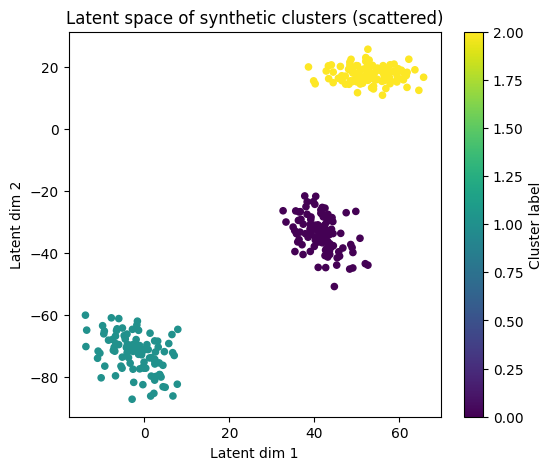

In [10]:
# --- Extract embeddings ---
model.eval()
with torch.no_grad():
    _, embeddings = model(X)
embeddings = embeddings.numpy()

# --- Visualize the 2D embedding space ---
plt.figure(figsize=(6,5))
plt.scatter(embeddings[:,0], embeddings[:,1], c=labels, cmap='viridis', s=20)
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.title('Latent space of synthetic clusters (scattered)')
plt.colorbar(label='Cluster label')
plt.show()

# Extra learning material

### Visualizing concepts:
- [Gentle dive into the maths](https://medium.com/data-science/gentle-dive-into-math-behind-convolutional-neural-networks-79a07dd44cf9)
- [CNNS for dummies](https://medium.com/@prathammodi001/convolutional-neural-networks-for-dummies-a-step-by-step-cnn-tutorial-e68f464d608f)

### Hands-on implementation examples
- [Autoencoder in PyTorch with CUDA](https://github.com/E008001/Autoencoder-in-Pytorch)
- [Friendly and well-explained tutorial](https://www.digitalocean.com/community/tutorials/convolutional-autoencoder)
- [Very complete tutorial](https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/)